# Import Libraries

In [3]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
from tqdm import tqdm

# Create Custom Dataset Class

In [4]:
class TACO(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(annotation_file) as f:
            self.annotations = json.load(f)
        self.images = list(self.annotations["images"])
        self.categories = {c["id"]: c["name"] for c in self.annotations["categories"]}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_path = os.path.join(self.root, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")

        # Process annotations
        annotations = [
            a for a in self.annotations["annotations"] if a["image_id"] == image_info["id"]
        ]
        boxes = []
        labels = []
        for ann in annotations:
            bbox = ann["bbox"]
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            labels.append(ann["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target

# Transformation to 224 x 224 Pixel

In [6]:
resize_to = 224
print(f"The images will be resized to {resize_to} * {resize_to} pixels")


The images will be resized to 224 * 224 pixels


In [7]:
from torchvision.transforms import Compose, Resize, ToTensor

transform = Compose([
    Resize((resize_to, resize_to)),  # Resize images
    ToTensor(),          # Convert to tensor
])

# Splitting Dataset

In [8]:
import json
import os
import random

# Load the full annotations
with open("TACO-master/data/annotations.json", 'r') as f:
    full_annotations = json.load(f)

# Extract images and annotations
images = full_annotations["images"]
annotations = full_annotations["annotations"]

# Split ratio
train_ratio = 0.8
random.shuffle(images)  # Shuffle images randomly
split_index = int(len(images) * train_ratio)

# Split images
train_images = images[:split_index]
test_images = images[split_index:]

# Create sets of image IDs for lookup
train_image_ids = {img["id"] for img in train_images}
test_image_ids = {img["id"] for img in test_images}

# Split annotations based on image IDs
train_annotations = [ann for ann in annotations if ann["image_id"] in train_image_ids]
test_annotations = [ann for ann in annotations if ann["image_id"] in test_image_ids]

# Construct training and testing annotation files
train_annotations_dict = {
    "info": full_annotations["info"],
    "licenses": full_annotations.get("licenses", []),
    "images": train_images,
    "annotations": train_annotations,
    "categories": full_annotations["categories"],
}

test_annotations_dict = {
    "info": full_annotations["info"],
    "licenses": full_annotations.get("licenses", []),
    "images": test_images,
    "annotations": test_annotations,
    "categories": full_annotations["categories"],
}

# Save to new JSON files
os.makedirs("split_data", exist_ok=True)
with open("TACO-master/data/train_annotations.json", 'w') as f:
    json.dump(train_annotations_dict, f)
with open("TACO-master/data/test_annotations.json", 'w') as f:
    json.dump(test_annotations_dict, f)

print("Dataset split completed. Train and test annotations saved in 'split_data' directory.")


Dataset split completed. Train and test annotations saved in 'split_data' directory.


# Define Path and DataLoader

In [9]:
train_dataset = TACO(
    root="TACO-master/data", 
    annotation_file="TACO-master/data/train_annotations.json", 
    transforms=transform
)

test_dataset = TACO(
    root="TACO-master/data", 
    annotation_file="TACO-master/data/test_annotations.json", 
    transforms=transform
)


train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=lambda x: tuple(zip(*x))
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=lambda x: tuple(zip(*x))
)

# Model Initialization

In [10]:
# Model Initialization
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify number of classes (background + categories)
num_classes = len(train_dataset.categories) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


c:\jackies\Code\Anaconda3\envs\taco-rcnn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\jackies\Code\Anaconda3\envs\taco-rcnn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training

Inspect before running

In [11]:
# Inspect the first image and its labels
image, target = train_dataset[0]  # Access the first item
print("Image Shape:", image.shape)
print("Target (Labels and Boxes):", target)


Image Shape: torch.Size([3, 224, 224])
Target (Labels and Boxes): {'boxes': tensor([[1.3200e+03, 1.7910e+03, 1.9360e+03, 2.2460e+03],
        [1.0000e+00, 6.6400e+02, 1.2210e+03, 1.9980e+03],
        [1.2420e+03, 3.3300e+02, 2.4480e+03, 1.2930e+03]]), 'labels': tensor([47, 44, 39])}


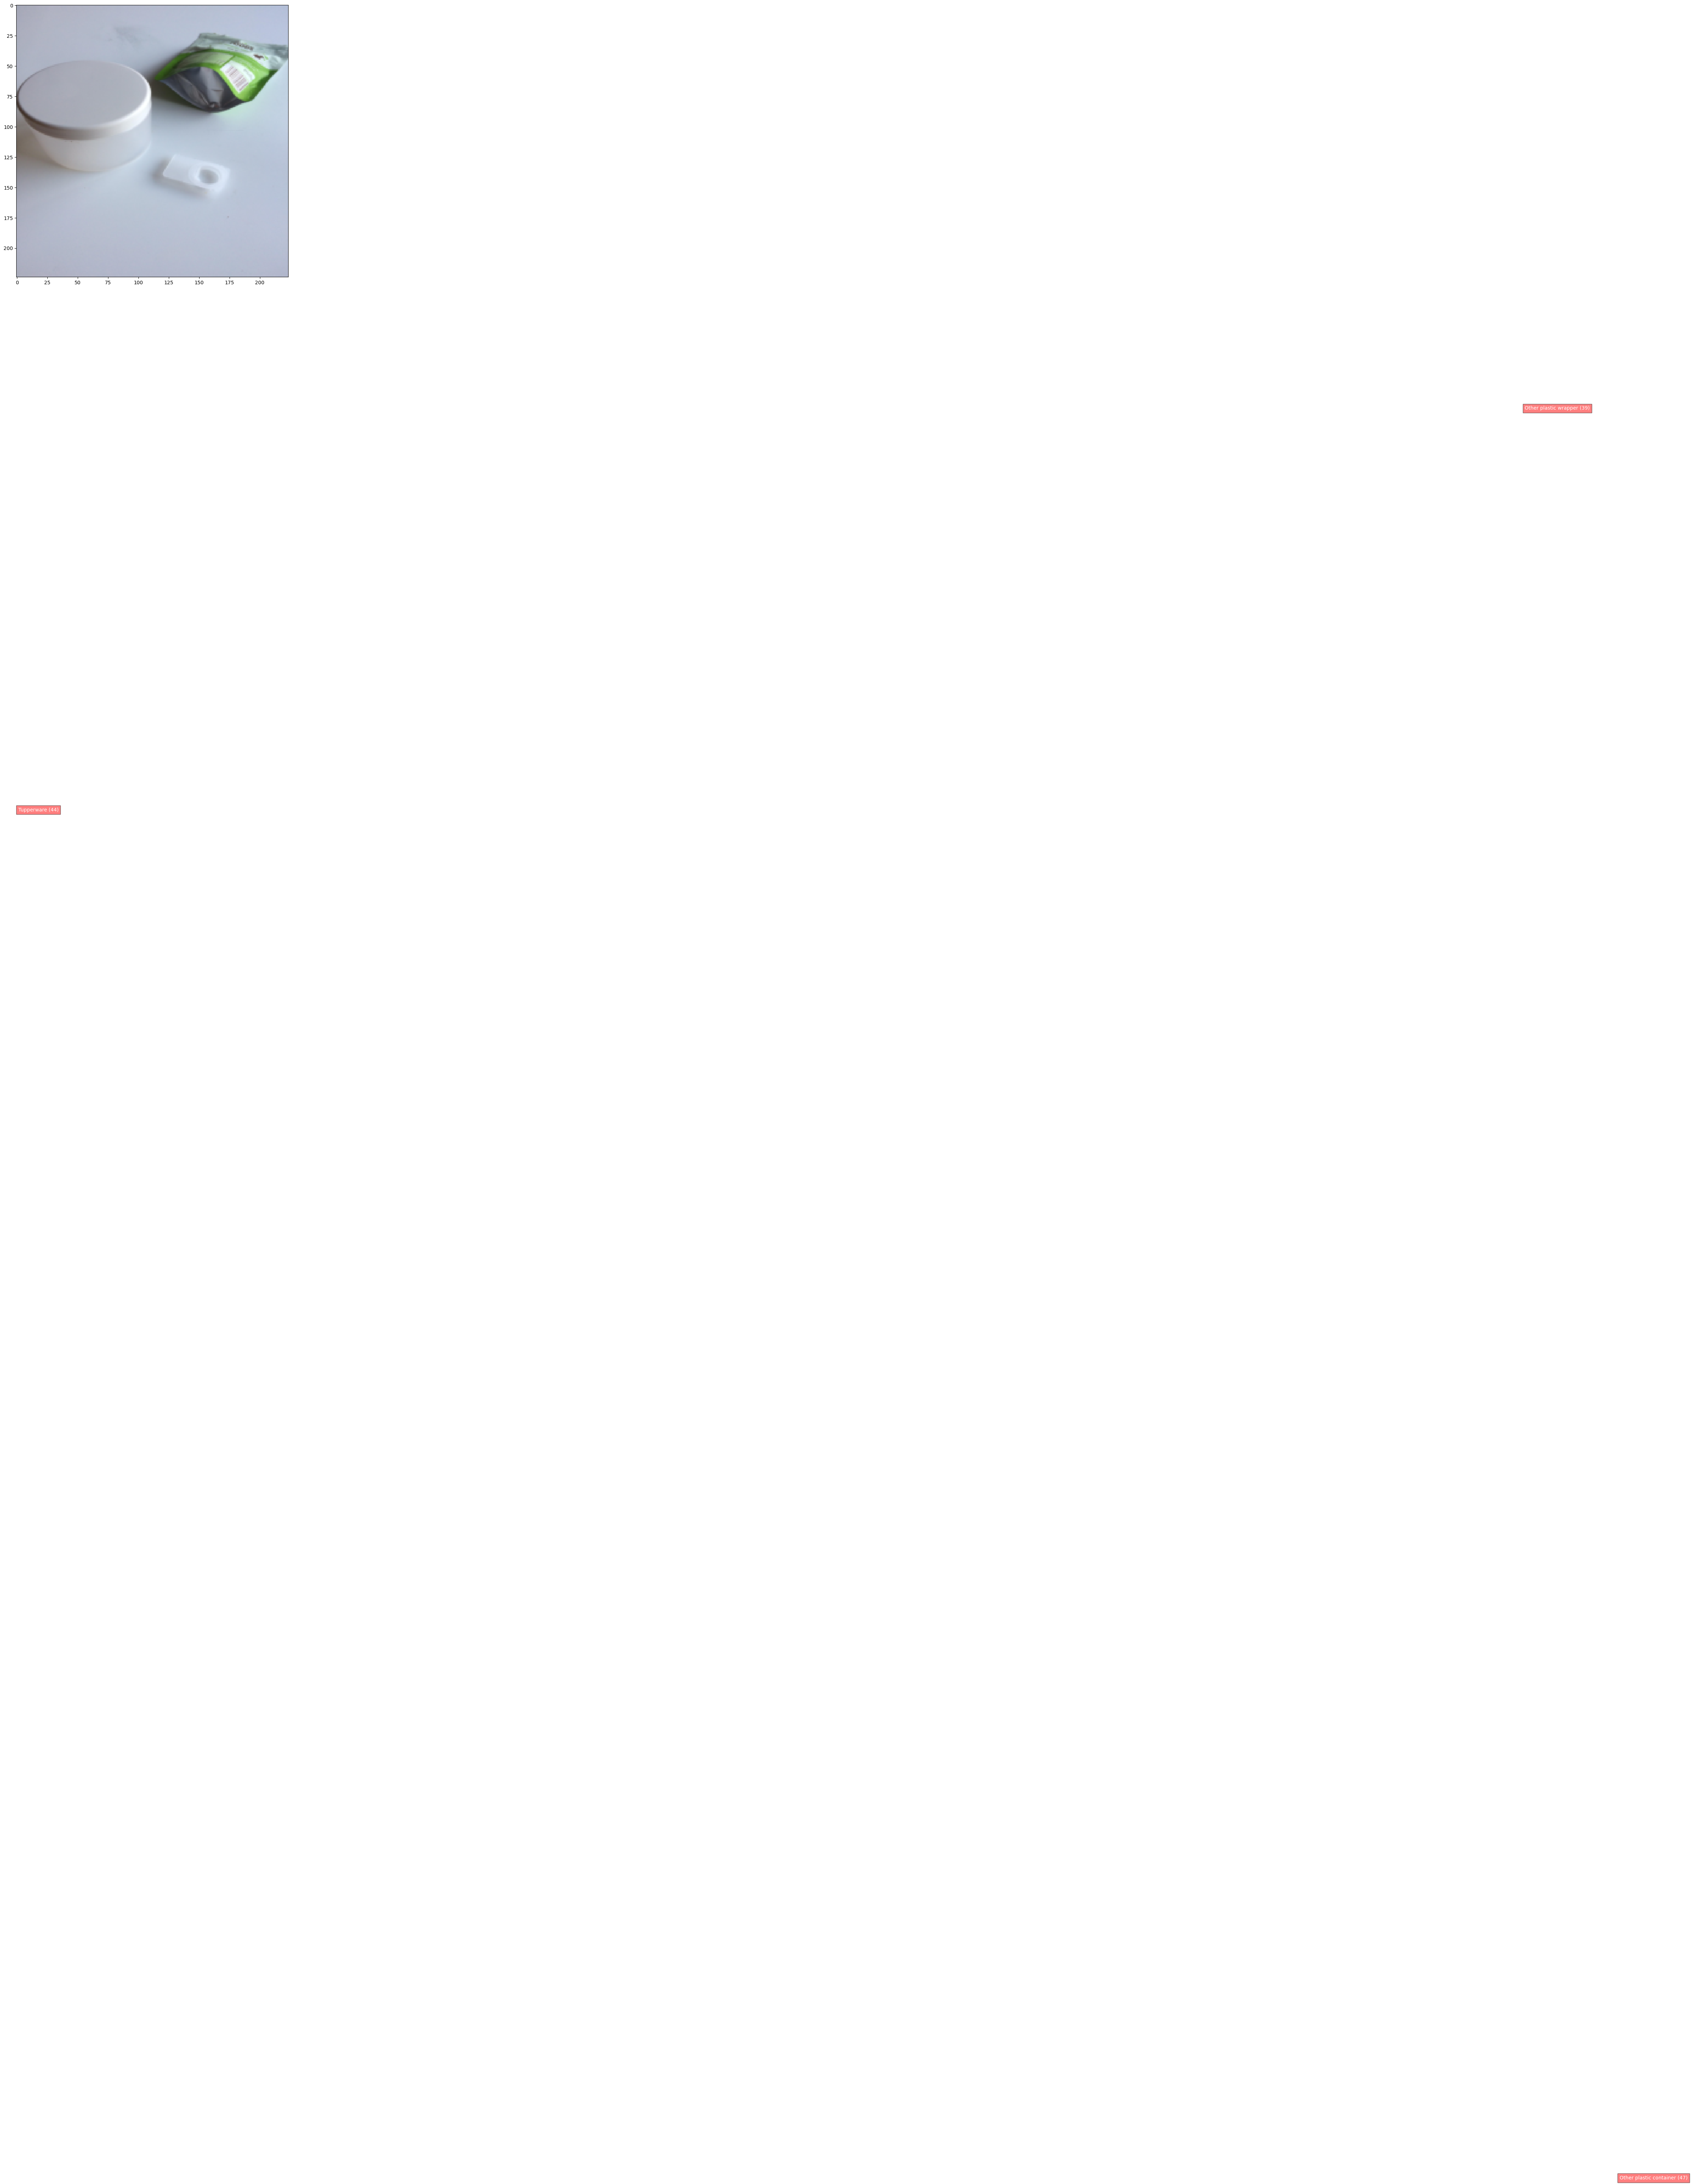

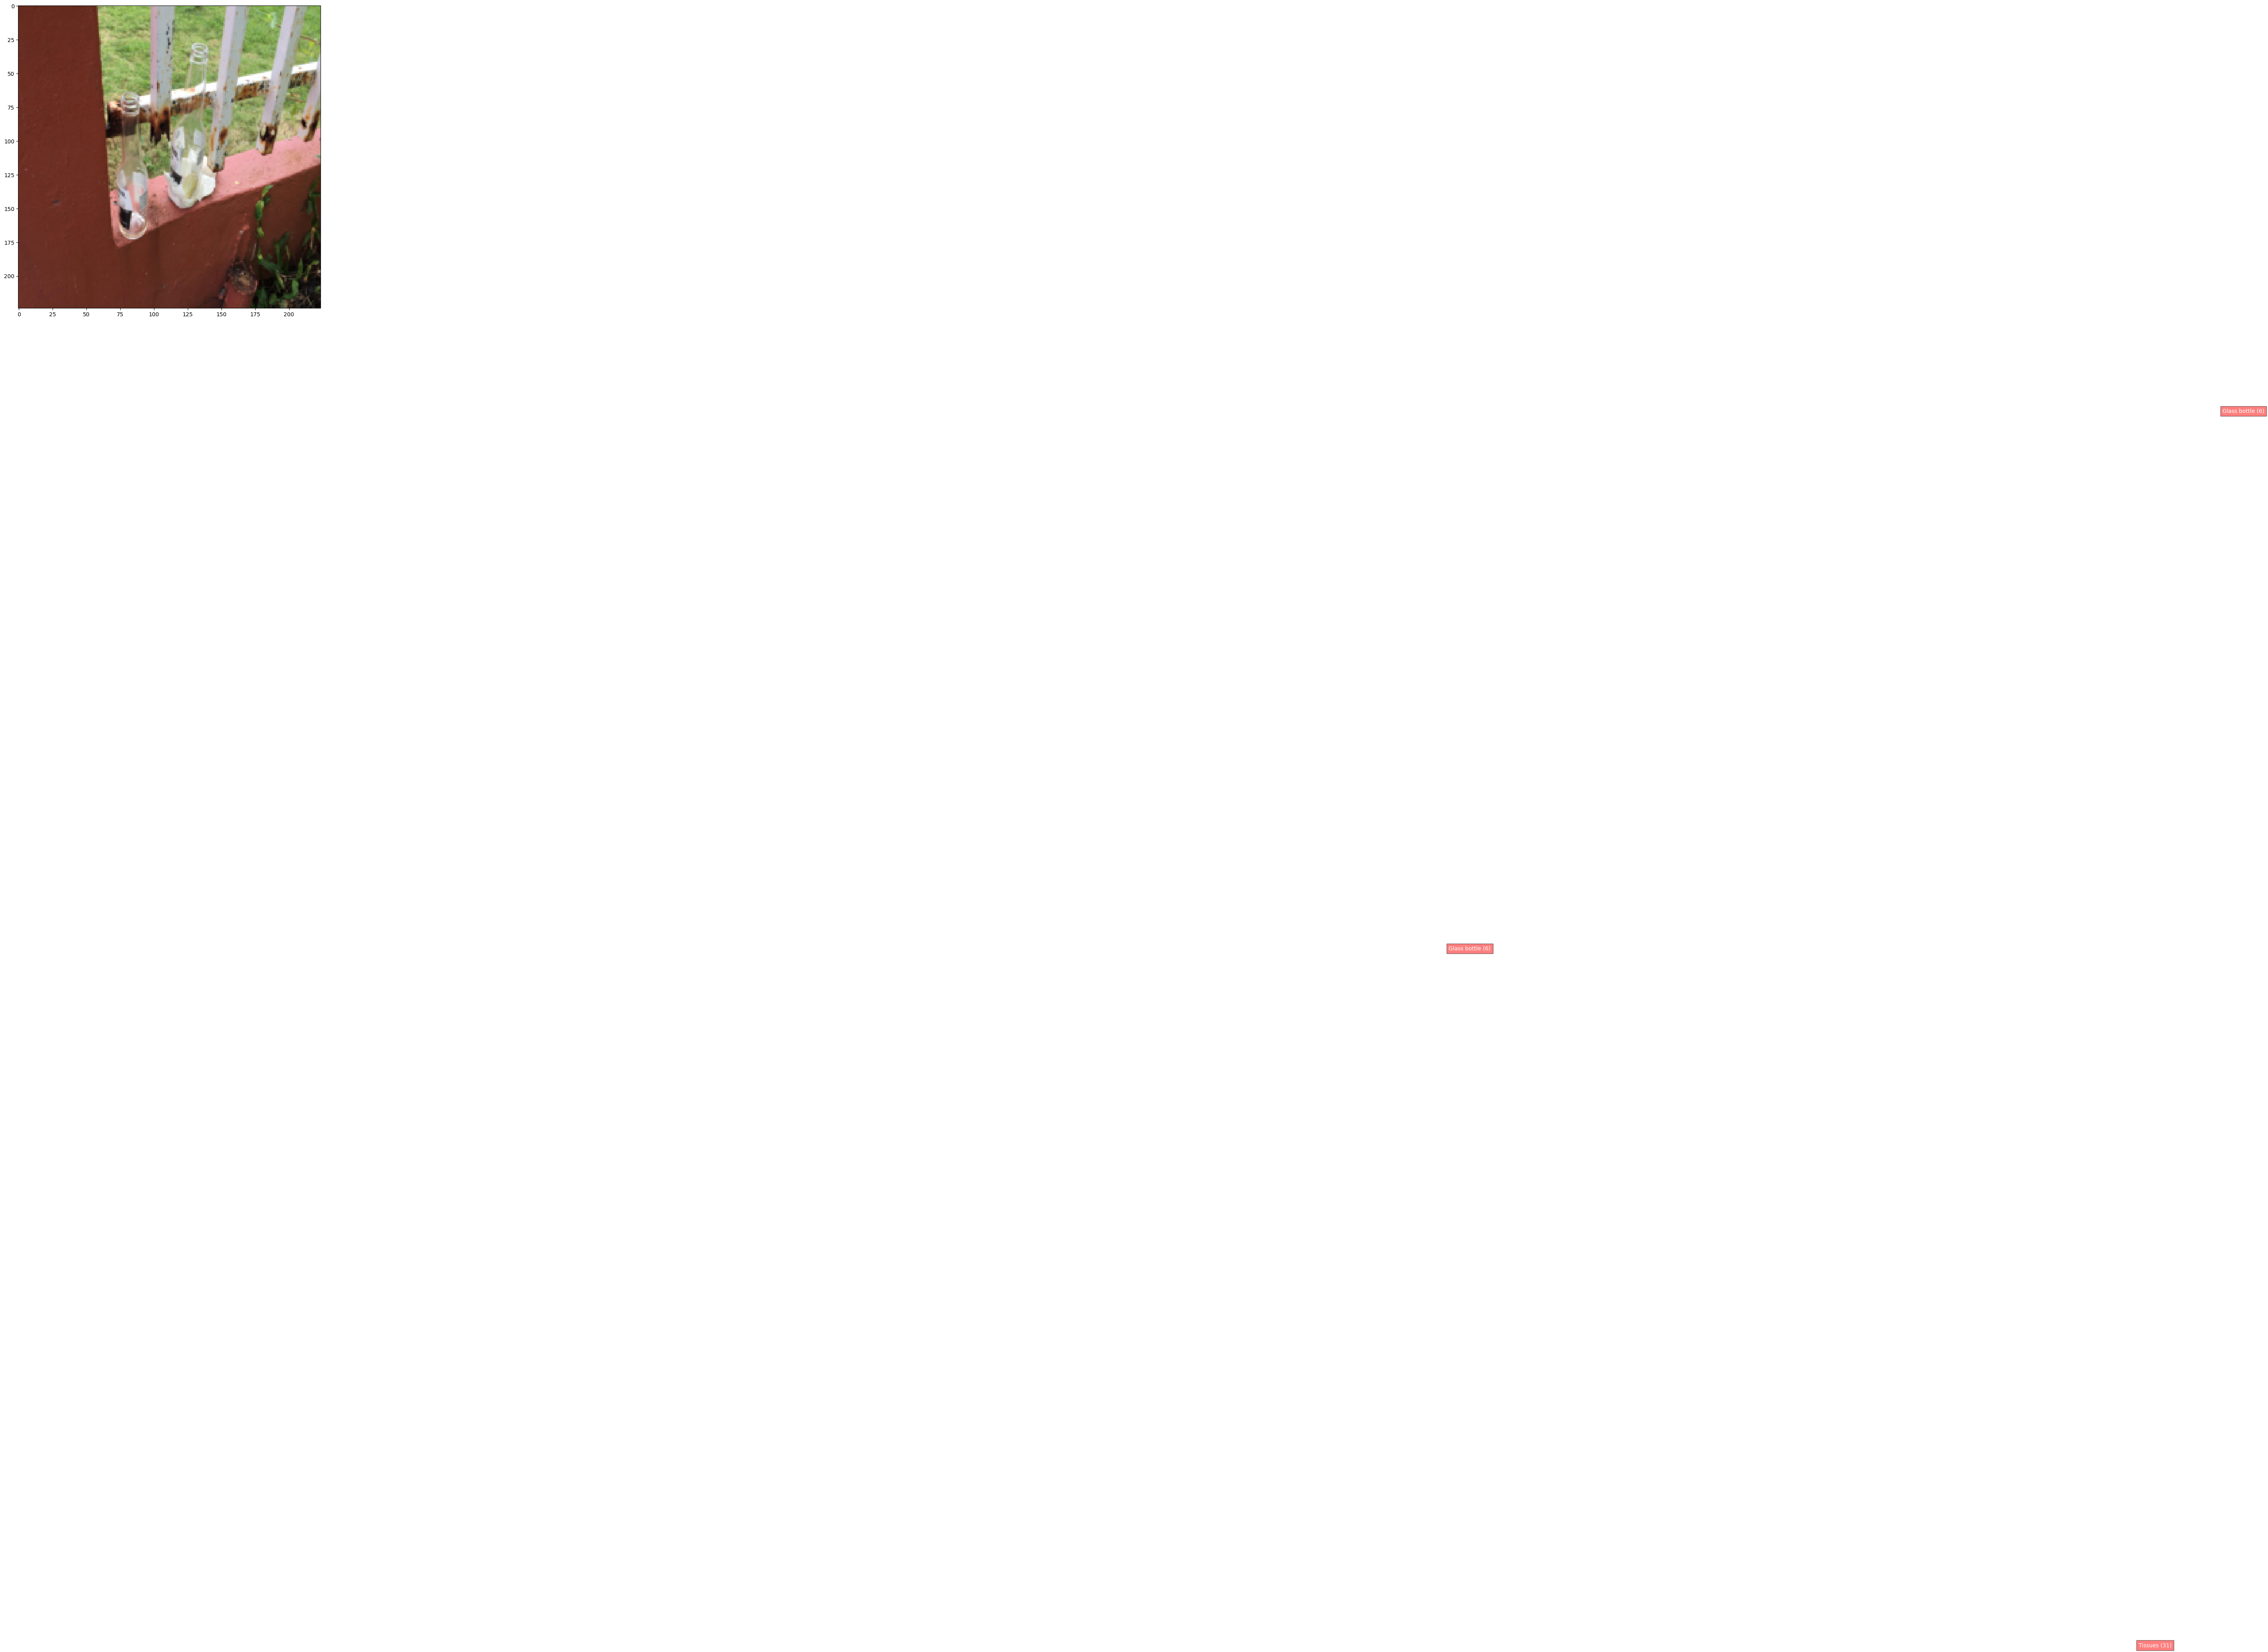

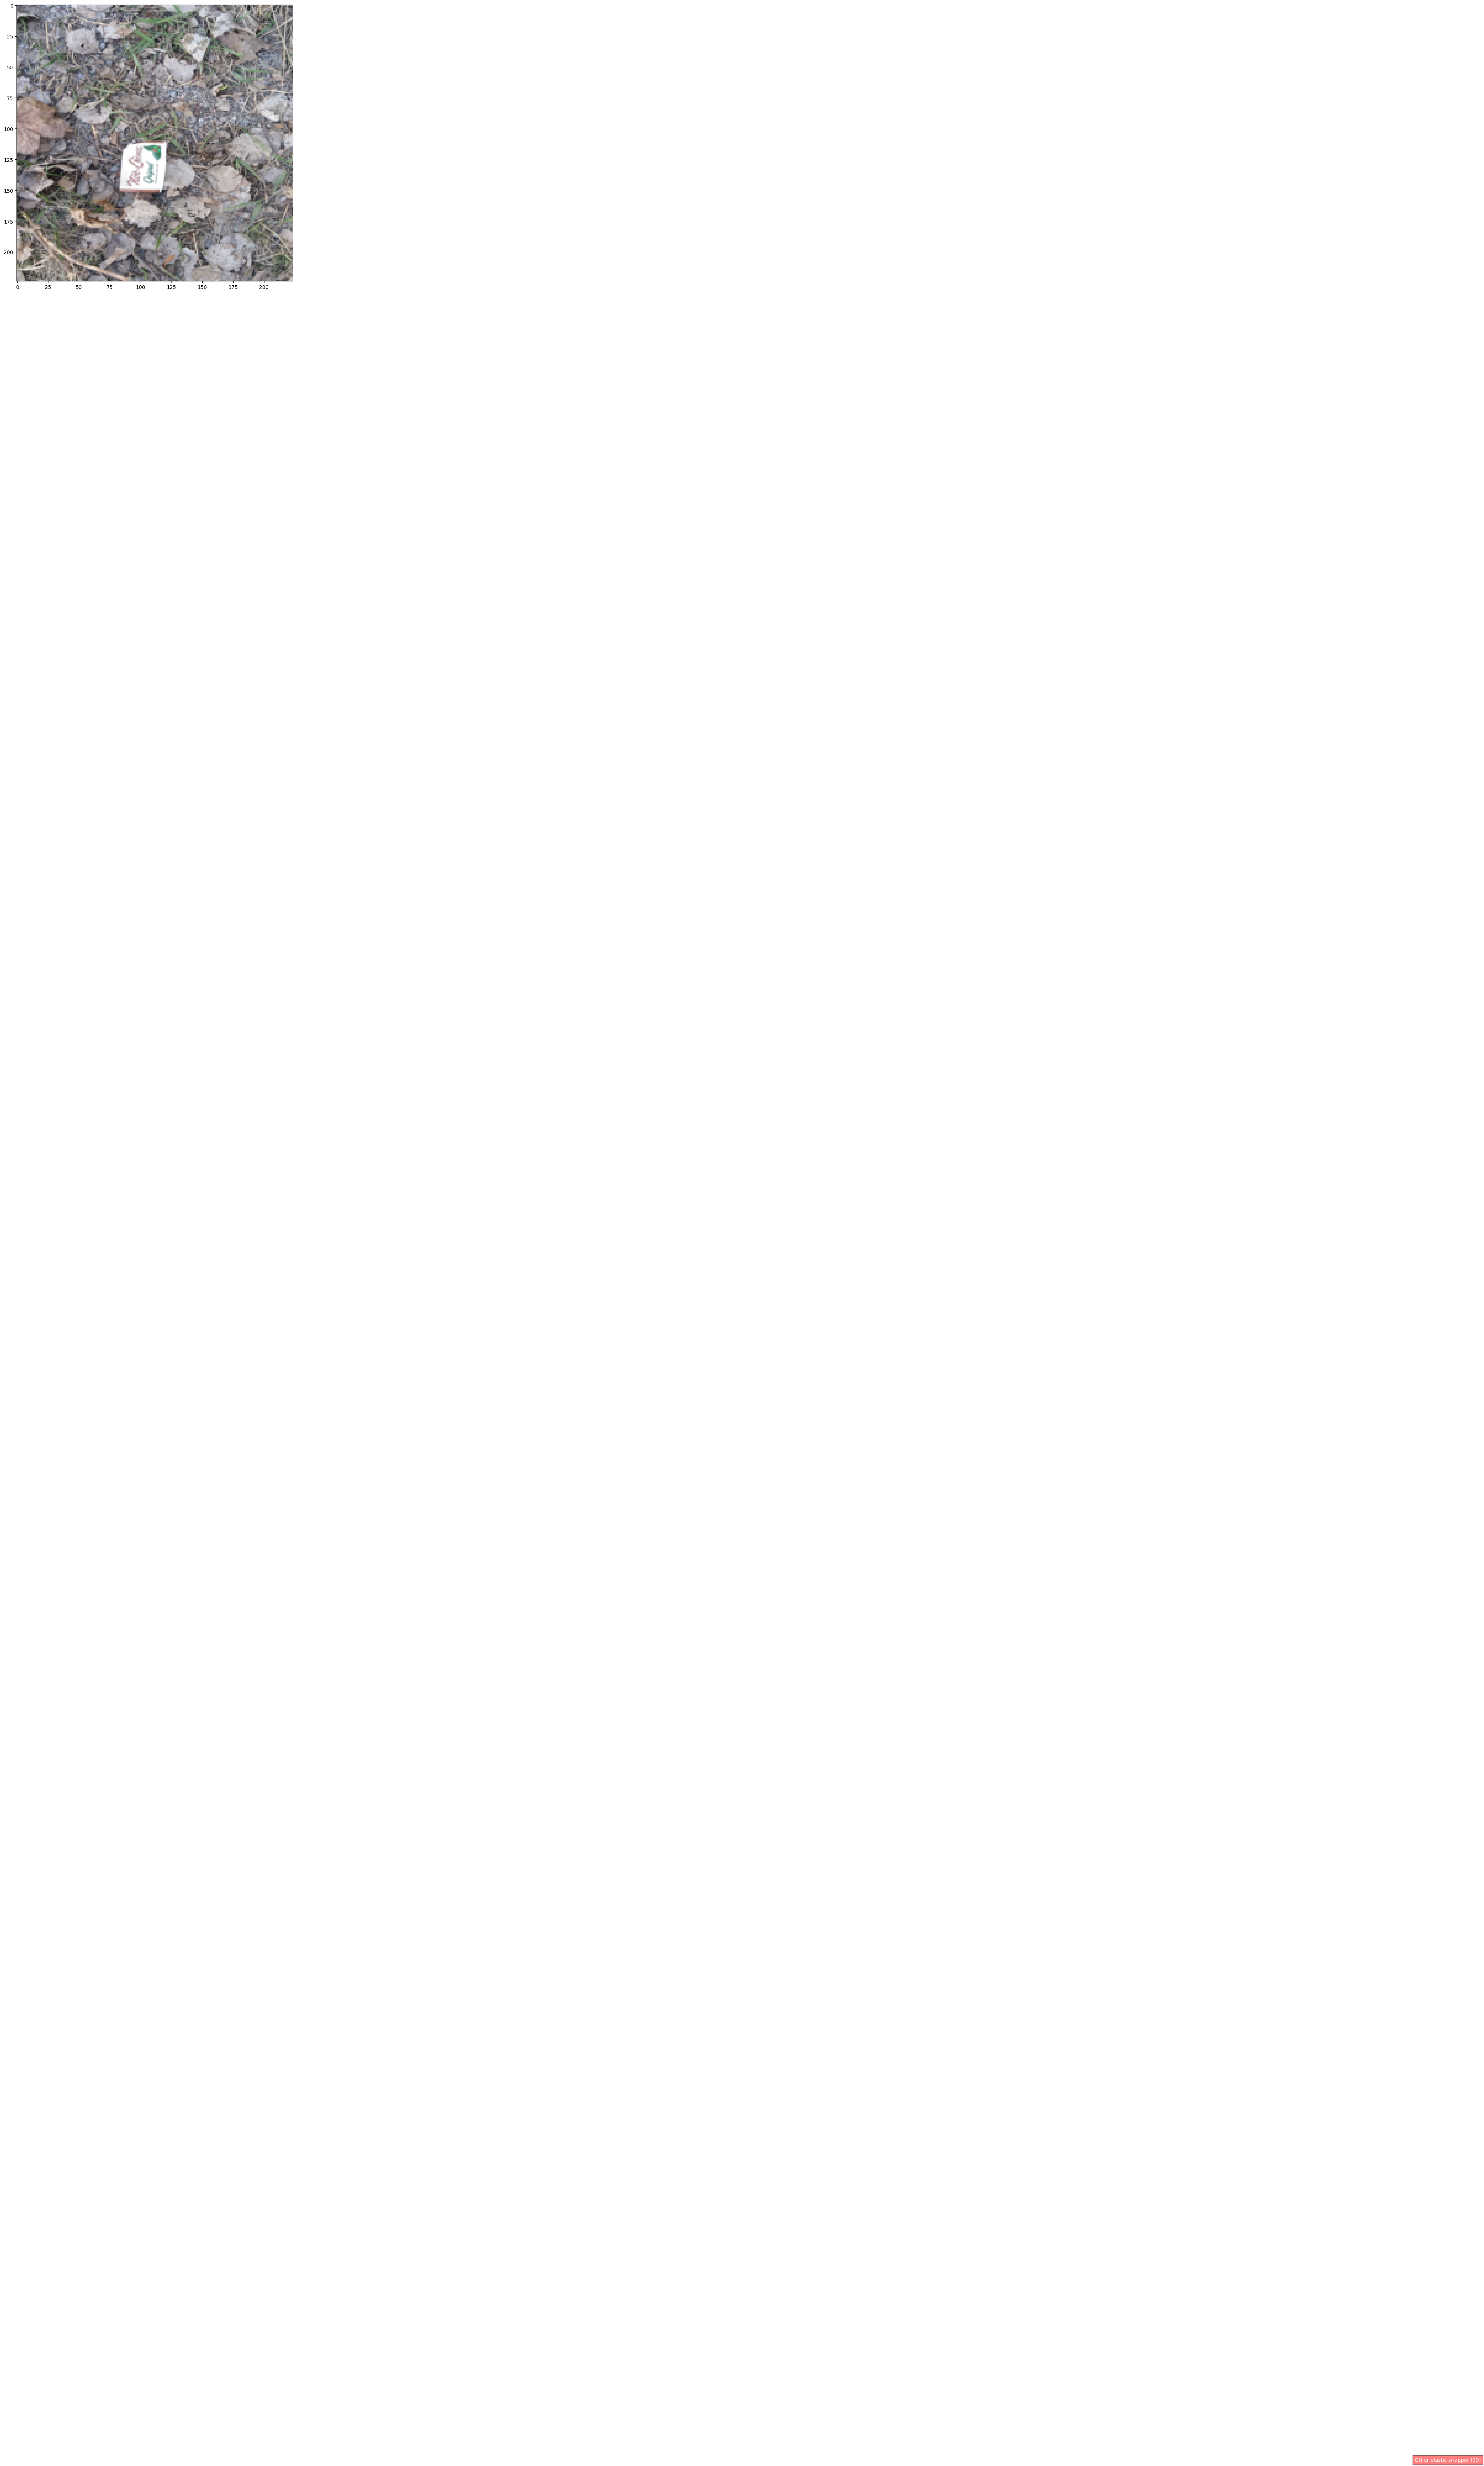

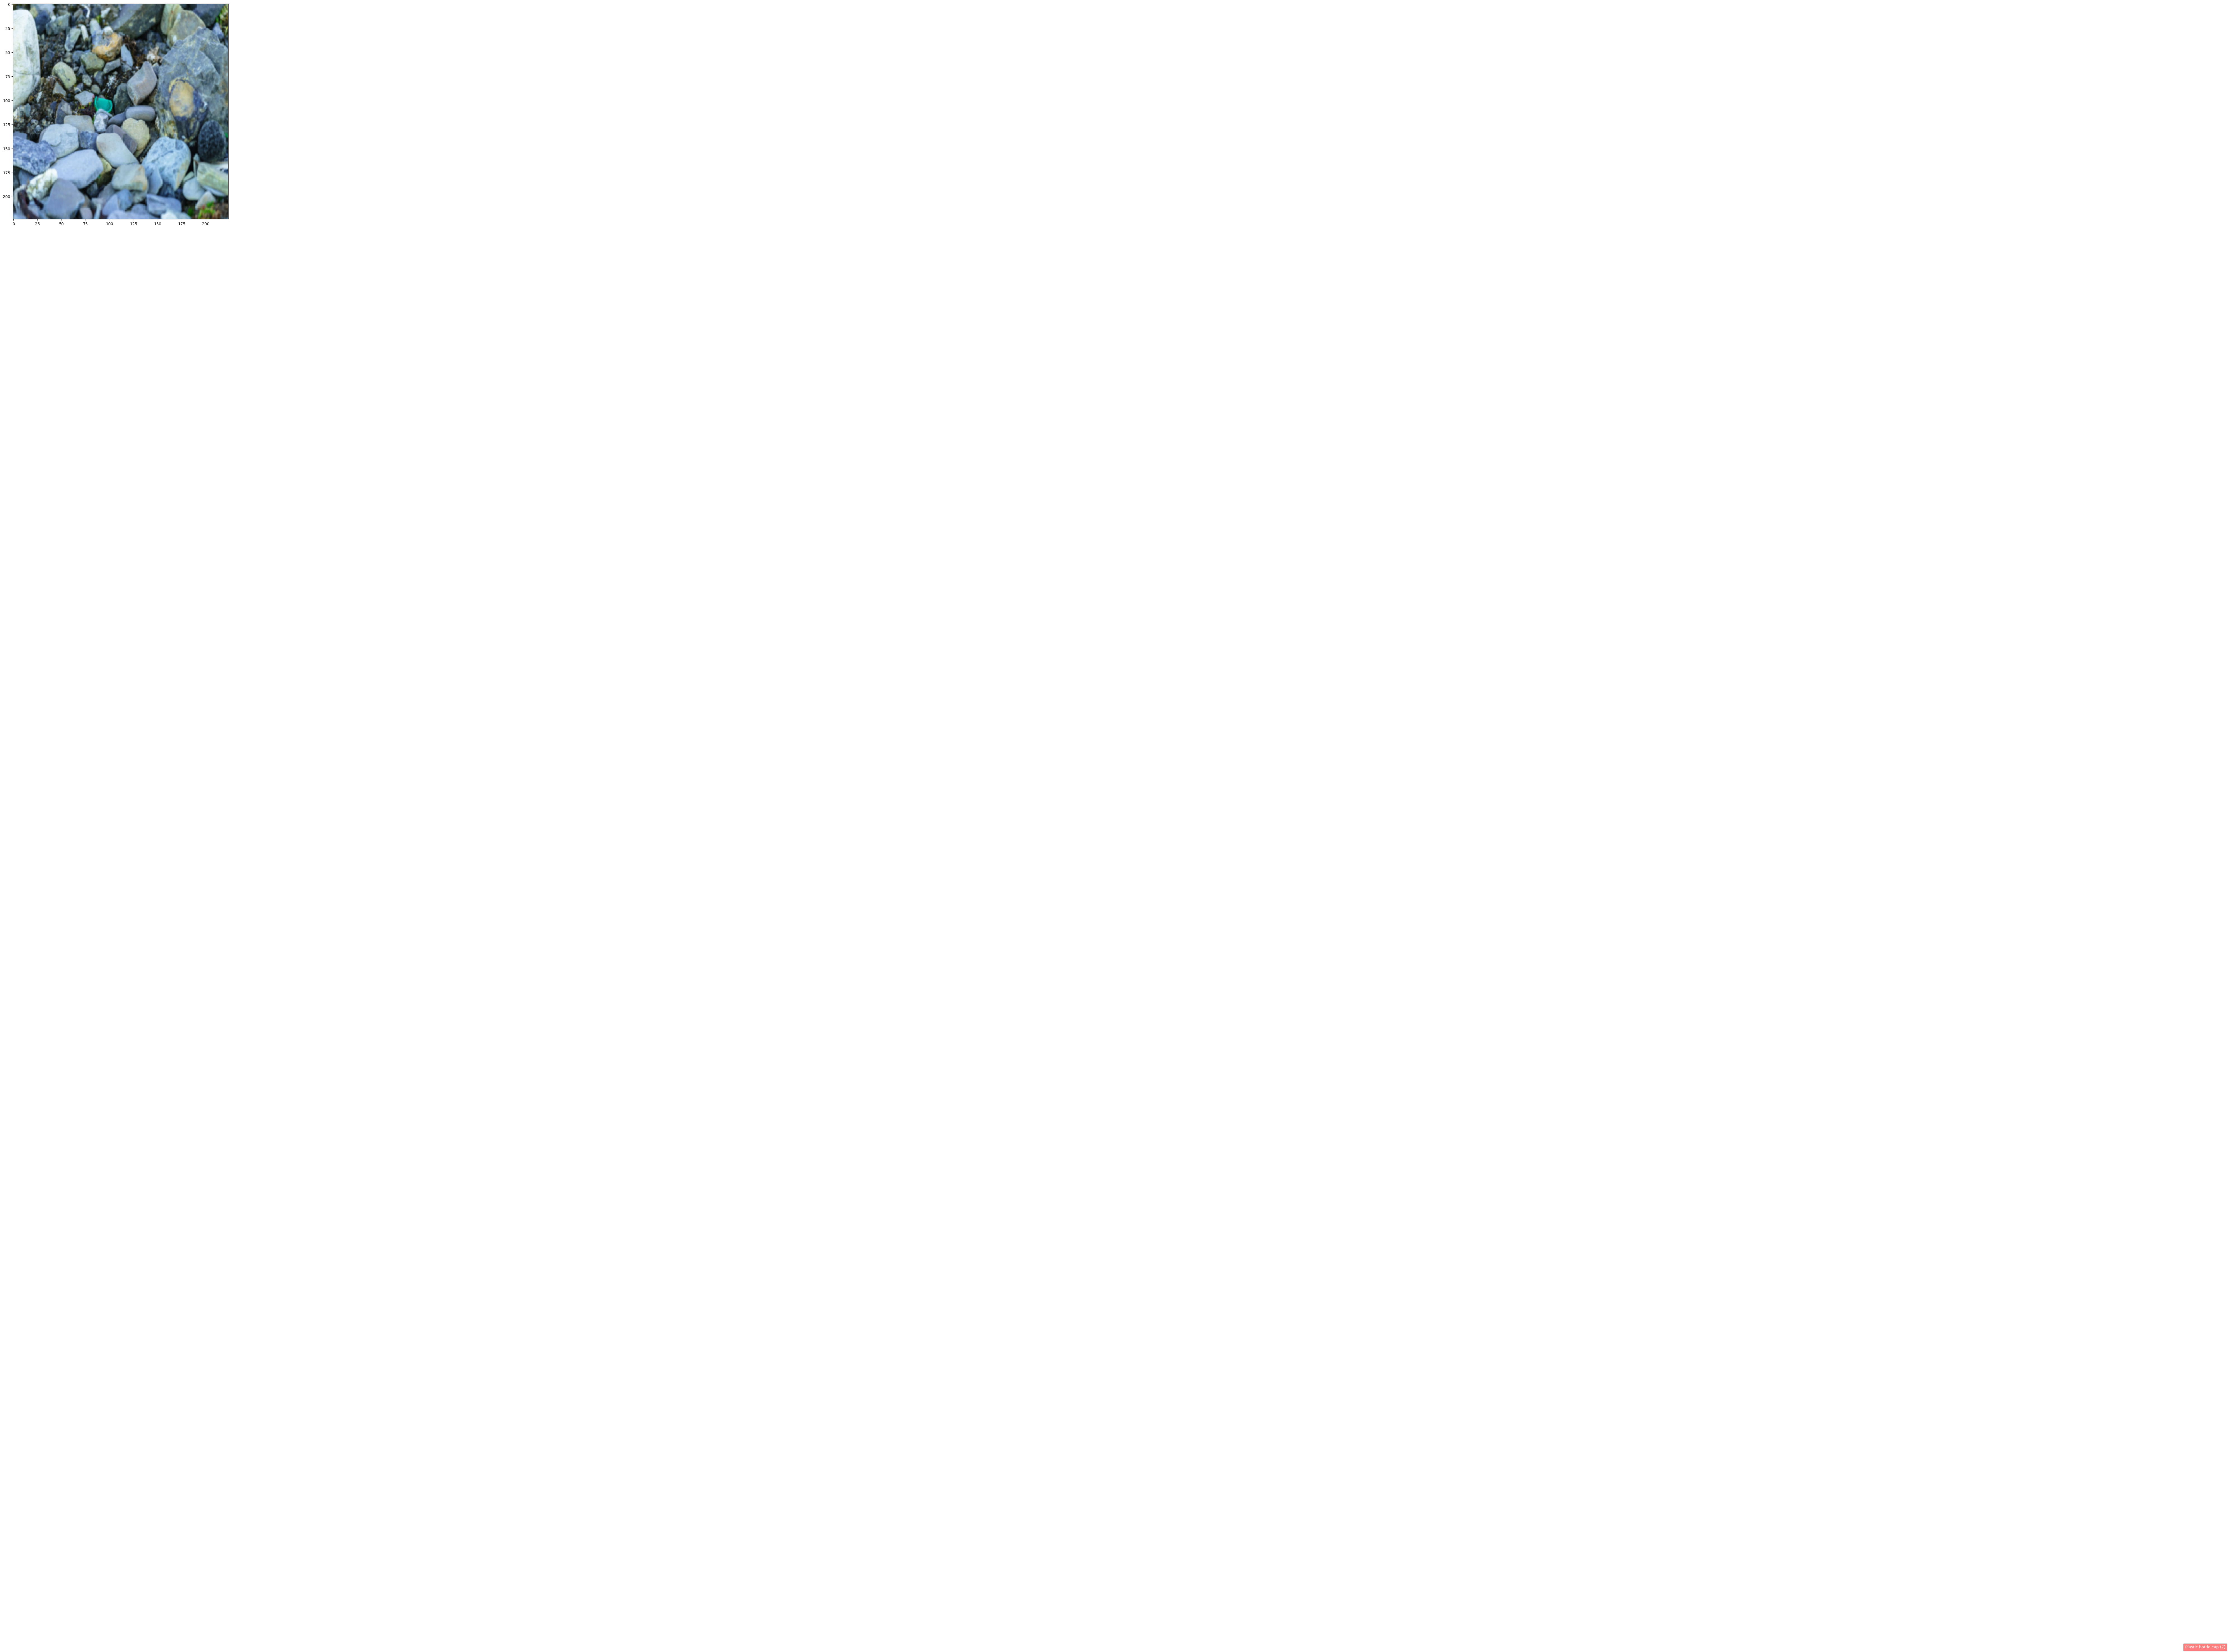

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# Load categories from annotations_unofficial.json
with open('TACO-master/data/annotations_unofficial.json', 'r') as f:
    annotations = json.load(f)

# Create a dictionary mapping class IDs to class names
class_id_to_name = {cat['id']: cat['name'] for cat in annotations['categories']}

# Visualization function
def visualize_dataset(dataset, num_images=5):
    for i in range(num_images):
        image, target = dataset[i]  # Access image and its labels
        boxes = target['boxes'].numpy()  # Bounding boxes
        labels = target['labels'].numpy()  # Class labels

        # Plot image
        image = image.permute(1, 2, 0).numpy()  # Convert to HxWxC format
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)

        # Plot bounding boxes with translated class names
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            # Translate label ID to class name
            class_name = class_id_to_name.get(label, f"Unknown ({label})")
            ax.text(x1, y1, f"{class_name} ({label})", color='white', 
                    bbox=dict(facecolor='red', alpha=0.5))

        plt.show()

# Visualize first 5 images
visualize_dataset(train_dataset, num_images=5)



In [ ]:
# Training Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5  # Example value
loss_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, targets) in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {epoch_loss:.4f}")

# Visualize Training Loss*
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


Epoch 1/5:  54%|█████▍    | 163/300 [1:40:17<1:24:17, 36.92s/it, loss=0.665]


In [19]:
print(loss_values)  # Daftar loss dari loop pelatihan


[51682.3585395813, 30782.5150680542, 30660.043167114258, 30631.521560668945, 30044.617084503174, 29989.644340515137, 29998.60097503662, 30152.48420715332, 29949.725860595703, 29607.82004928589]


# Testing

In [8]:
# Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)
            results.append(outputs)
    return results

# Evaluate on Test Data
test_results = evaluate_model(model, test_loader, device)


Evaluating: 100%|██████████| 75/75 [02:02<00:00,  1.64s/it]


# Visualizing Predictions

In [15]:
# Visualize predictions on a few test images
import matplotlib.patches as patches

# Memeriksa format data test_results
print(type(test_results))  # data type
print(test_results[:1])    # example of first element

<class 'list'>
[[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]]


In [16]:
# Perbaiki fungsi visualisasi
def visualize_predictions(dataset, predictions, num_images=5):
    predictions = predictions[0]  # Akses elemen pertama karena nested list
    for i in range(min(len(predictions), num_images)):
        image, target = dataset[i]
        pred = predictions[i]  # Akses elemen ke-i dari list

        # Validasi jika tensor kosong
        if pred['boxes'].shape[0] == 0:
            print(f"No predictions for image {i}. Skipping visualization.")
            continue

        pred_boxes = pred['boxes'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()

        # Plot gambar dengan bounding box
        image = image.permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)

        # Tambahkan bounding box ke plot
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score > 0.5:  # Hanya prediksi dengan skor > threshold
                x1, y1, x2, y2 = box
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(
                    x1, y1, f"Class: {label}, Score: {score:.2f}",
                    color='white', bbox=dict(facecolor='red', alpha=0.5)
                )
        plt.show()

In [ ]:
# Jalankan ulang visualisasi
visualize_predictions(test_dataset, test_results, num_images=5)

# Saving Model

In [20]:
# Save the trained model state dictionary
model_save_path = "faster_rcnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to faster_rcnn_model.pth


# Load the model

In [10]:
# Load the model state dictionary
model_load_path = "faster_rcnn_model.pth"
model.load_state_dict(torch.load(model_load_path))
model.eval()  # Set the model to evaluation mode
print(f"Model loaded from {model_load_path}")


Model loaded from faster_rcnn_model.pth


C:\Users\ivana\AppData\Local\Temp\ipykernel_12908\651911550.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
